In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

import trimesh
import math

# Loading all data

In [2]:
base_path = os.getcwd() + "//UoY//"

In [3]:
file_names = os.listdir(base_path)
base_path = os.getcwd() + "//UoY//"
#files = os.listdir(base_path)
# obj_files = []
# for file in files:
#     if "obj" in file: 
#         obj_files.append(file)
obj_files = ["00050-10-moo25nnngy.obj", "00024-10-mww28nnngy.obj",
             "00136-08-mww38nnngy.obj","00060-08-mww34ngngn.obj", 
             "00067-10-mww34ngngy.obj", "00026-10-mww26ngngy.obj",
             "00133-08-mww55bgngy.obj","00026-08-mww26ngngy.obj", 
             "00068-10-fww44nnngy.obj", "00069-10-mac40ngngy.obj",
             "00068-08-fww44nnngy.obj", "00132-08-mww26nnngn.obj"]
mesh = trimesh.load(base_path+obj_files[0])

# Using trimesh package

In [4]:
mesh.visual = mesh.visual.to_color()

In [5]:
for index, facet in enumerate(mesh.visual.vertex_colors):
    mesh.visual.vertex_colors[index] = [0,255,0,0]
mesh.show()

# Preprocessing - Smoothing

In [6]:
laplacian_smoothing_mesh = mesh.copy()
trimesh.smoothing.filter_laplacian(laplacian_smoothing_mesh)
laplacian_smoothing_mesh.show()

In [7]:
humphrey_smoothing_mesh = mesh.copy()
trimesh.smoothing.filter_humphrey(humphrey_smoothing_mesh)
humphrey_smoothing_mesh.show()

In [8]:
taubin_smoothing_mesh = mesh.copy()
trimesh.smoothing.filter_taubin(taubin_smoothing_mesh)
taubin_smoothing_mesh.show()

In [9]:
laplacian_calculation_smoothing_mesh = mesh.copy()
trimesh.smoothing.laplacian_calculation(laplacian_calculation_smoothing_mesh)
laplacian_calculation_smoothing_mesh.show()

In [10]:
smoothing_mesh = taubin_smoothing_mesh.copy()

# Preprocessing - Cropping

In [11]:
class CroppingFilter():
    def __init__(self):
        self.mesh = None
        self.noseIndex = 0
        self.depthSortVertices = None
        
    def InitMeshAttributes(self, mesh):
        self.mesh = mesh.copy()
        self.depthSortVertices = sorted(self.mesh.vertices, key = lambda vertice : vertice[2], reverse = True)
        
    def GetMesh(self):
        return self.mesh
    
    def GetNoseIndex(self):
        return self.noseIndex
        
    def Filtering(self, mesh, r):
        self.InitMeshAttributes(mesh)
        preSphereVerticeNum = 0
        for vertice in self.depthSortVertices:
            mesh = self.GetShpereMesh(self.mesh, vertice, r)
            mesh.show()
            curSphereVerticeNum = len(mesh.vertices)
            if curSphereVerticeNum - preSphereVerticeNum > 150:
                self.noseIndex = self.FindNoseIndex(mesh.vertices, vertice)
                self.mesh = mesh
                break
            preSphereVerticeNum = curSphereVerticeNum

    def GetShpereMesh(self, originMesh, centerVertice, r):    # private
        mesh = originMesh.copy()
        sphereIndexes = self.GetSphereIndexes(mesh, centerVertice, r)
        mesh = self.RemoveFaces(mesh, sphereIndexes)
        mesh = self.RemoveVertices(mesh)
        return mesh

    def GetSphereIndexes(self, mesh, centerVertice, r):    # private
        sphereIndexes = np.array([])
        for index, vertice in enumerate(mesh.vertices):
            if self.EuclideanDistance(centerVertice, vertice, 3) < r:
                sphereIndexes = np.append(sphereIndexes, index)
        return sphereIndexes

    def EuclideanDistance(self, lvertice, rvertice, dimensional):    # private
        euclideanDistance = 0
        for d in range(dimensional):
            euclideanDistance += pow(lvertice[d] - rvertice[d], 2)
        euclideanDistance = math.sqrt(euclideanDistance)
        return euclideanDistance
    
    """
        Rename the name of function and parameter
    """
    def RemoveFaces(self, mesh, sphereIndexes):    # private
        faces = np.empty((0,3), int)
        for face in mesh.faces:
            if self.IsFaceCompositionOfShpereVertices(face, sphereIndexes):
                faces = np.append(faces, np.array([face]), axis=0)
        mesh.faces = faces
        return mesh

    def IsFaceCompositionOfShpereVertices(self, face, sphereIndexes):    # private
        for vertice in face:
            if not(vertice in sphereIndexes):
                return False
        return True

    def RemoveVertices(self, mesh):    # private
        mesh.remove_unreferenced_vertices()
        return mesh
    
    def FindNoseIndex(self, vertices, vertice):    # private
        for index in range(len(vertices)):
            if (np.array(vertices[index]) == np.array(vertice)).all():
                return index
        return -1

In [1]:
croppingFilter = CroppingFilter()
croppingFilter.Filtering(smoothing_mesh, 125)
cropping_mesh = croppingFilter.GetMesh()
# cropping_mesh.visual.vertex_colors[croppingFilter.GetNoseIndex()] = [255,0,0,0]
cropping_mesh.show()

NameError: name 'CroppingFilter' is not defined

In [2]:
class BoundaryVertex():
    def __init__(self, edges, triangles):
        self.one_ring_edges = np.array(edges)
        self.one_ring_triangles = np.array(triangles)
        
    def get_one_ring_edges(self):
        return self.one_ring_edges
    
    def get_one_ring_triangles(self):
        return self.one_ring_triangles

In [3]:
class BoundaryVertexTest(unittest.TestCase):
    @classmethod
    def setUpClass(self):
        self.boundary_vertex = BoundaryVertex(np.array([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]), 
                                              np.array([[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 5], [0, 5, 1]]))
        
    def test_if_has_5_1_ring_edges_return_edge_list(self):
        self.assertTrue(np.alltrue(self.boundary_vertex.get_one_ring_edges() == 
                                   np.array([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]])))
        
    def test_if_has_5_1_ring_triangles_return_triangle_list(self):
        self.assertTrue(np.alltrue(self.boundary_vertex.get_one_ring_triangles() == 
                                   np.array([[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 5], [0, 5, 1]])))
        
unittest.main(argv=[''], verbosity=2, exit=False)

NameError: name 'unittest' is not defined

In [4]:
class BoundaryVertexChecker():
    def __init__(self, mesh):
        self.mesh = mesh
        self.all_one_ring_vertices = self.__get_all_one_ring_vertices(self.mesh)
        self.all_one_ring_triangles = self.__get_all_one_ring_triangles(self.mesh)
        
    def __get_all_one_ring_triangles(self, mesh):
        triangles = mesh.faces
        all_one_ring_triangles = [[] for i in range(len(mesh.vertices))]
        for triangle in triangles:
            for vertex in triangle:
                all_one_ring_triangles[vertex].append(triangle)
        return all_one_ring_triangles
        
    def __get_all_one_ring_vertices(self, mesh):
        graph = nx.from_edgelist(mesh.edges_unique)
        all_one_ring_vertices = [list(graph[i].keys()) for i in range(len(mesh.vertices))]
        return all_one_ring_vertices
        
    def is_boundary_vertex(self, vertex):
        idx_list = np.flatnonzero((self.mesh.vertices == vertex).all(1))
        idx = idx_list[0]
        return len(self.all_one_ring_vertices[idx]) != len(self.all_one_ring_triangles[idx])
        
m = trimesh.Trimesh([[-0.5, -0.5, -0.5], 
                     [-0.5, -0.5, 0.5], 
                     [-0.5, 0.5, -0.5], 
                     [-0.5, 0.5, 0.5], 
                     [ 0.5, -0.5, -0.5], 
                     [ 0.5, -0.5, 0.5], 
                     [ 0.5, 0.5, -0.5], 
                     [ 0.5, 0.5, 0.5]], 
                    [[1, 3, 0], 
                     [4, 1, 0], 
                     [0, 3, 2], 
                     [2, 4, 0], 
                     [5, 1, 4], 
                     [5, 7, 1], 
                     [3, 7, 2], 
                     [6, 4, 2], 
                     [2, 7, 6], 
                     [6, 5, 4], 
                     [7, 5, 6]])
m.vertex_neighbors

NameError: name 'trimesh' is not defined

In [ ]:
class BoundaryVertexCheckerTest(unittest.TestCase):
    @classmethod
    def setUpClass(self):
        self.mesh = trimesh.Trimesh([[-0.5, -0.5, -0.5], 
                                     [-0.5, -0.5, 0.5], 
                                     [-0.5, 0.5, -0.5], 
                                     [-0.5, 0.5, 0.5], 
                                     [ 0.5, -0.5, -0.5], 
                                     [ 0.5, -0.5, 0.5], 
                                     [ 0.5, 0.5, -0.5], 
                                     [ 0.5, 0.5, 0.5]], 
                                    [[1, 3, 0], 
                                     [4, 1, 0], 
                                     [0, 3, 2], 
                                     [2, 4, 0], 
                                     [5, 1, 4], 
                                     [5, 7, 1], 
                                     [3, 7, 2], 
                                     [6, 4, 2], 
                                     [2, 7, 6], 
                                     [6, 5, 4], 
                                     [7, 5, 6]])
        self.boundary_vertex_checker = BoundaryVertexChecker(self.mesh)
        
    def test_get_one_ring_vertices_should_get_whole_vertex_neighbors(self):
        correct_one_ring_vertices = [[1, 2, 3, 4], [0, 3, 4, 5, 7], [0, 3, 4, 6, 7], [0, 1, 2, 7], 
                                     [0, 1, 2, 5, 6], [1, 4, 6, 7], [2, 4, 5, 7], [1, 2, 3, 5, 6]]
        all_one_ring_vertices = self.boundary_vertex_checker._BoundaryVertexChecker__get_all_one_ring_vertices(self.mesh)
        for idx, one_ring_vertices in enumerate(all_one_ring_vertices):
            self.assertTrue(sorted(correct_one_ring_vertices[idx]) == sorted(one_ring_vertices))
            
    def test_get_one_ring_triangles_should_get_whole_vertex_related_triangles(self):
        correct_all_one_ring_triangles = [[[1, 3, 0], [4, 1, 0], [0, 3, 2], [2, 4, 0]], 
                                          [[1, 3, 0], [4, 1, 0], [5, 1, 4], [5, 7, 1]], 
                                          [[0, 3, 2], [2, 4, 0], [3, 7, 2], [6, 4, 2], [2, 7, 6]], 
                                          [[1, 3, 0], [0, 3, 2], [3, 7, 2]], 
                                          [[4, 1, 0], [2, 4, 0], [5, 1, 4], [6, 4, 2], [6, 5, 4]], 
                                          [[5, 1, 4], [5, 7, 1], [6, 5, 4], [7, 5, 6]], 
                                          [[6, 4, 2], [2, 7, 6], [6, 5, 4], [7, 5, 6]], 
                                          [[5, 7, 1], [3, 7, 2], [2, 7, 6], [7, 5, 6]]]
        all_one_ring_triangles = self.boundary_vertex_checker._BoundaryVertexChecker__get_all_one_ring_triangles(self.mesh)
        for idx, one_ring_triangles in enumerate(all_one_ring_triangles):
            correct_one_ring_triangles = set(map(tuple, correct_all_one_ring_triangles[idx]))
            one_ring_triangles = set(map(tuple, one_ring_triangles))
            self.assertTrue(not(correct_one_ring_triangles.difference(one_ring_triangles)))
                
    def test_if_vertex_not_boundary_vertex_then_should_be_false(self):
        self.assertFalse(self.boundary_vertex_checker.is_boundary_vertex([-0.5, -0.5, -0.5]))
        
    def test_if_vertex_is_boundary_vertex_then_should_be_true(self):
        self.assertTrue(self.boundary_vertex_checker.is_boundary_vertex([-0.5, -0.5, 0.5]))
        
unittest.main(argv=[''], verbosity=2, exit=False)

# Feature Selection

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin
class NDStandardScaler(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = StandardScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self

    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

In [14]:
from scipy import exp
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform
import random
class Features_Selector(object):
    def __init__(self):
        self.mesh = None 
    """
    For randomly generating the feaure points.
    Select_m_points is callable.
    
    Parameters:
    ----------
    mesh: {Trimesh}
    """
    
    def select_m_points(self, mesh, m=40):
        #randomly generate m points index
        selected_index = []
        iter_time = 0
        vertices = mesh.vertices
#         #method 1
#         while(len(selected_index)<m and iter_time<10000):
#             random_index = random.randint(0, len(vertices)-1)
#             if self.is_maintain_distance(vertices[random_index], vertices[selected_index], 20):
#                 selected_index.append(random_index)
#             iter_time+=1
        
        #method 2
        for index, point in enumerate(vertices):
            if len(selected_index) > m:
                break
            if self.is_maintain_distance(point, vertices[selected_index], 25):
                selected_index.append(index)
            
        #draw the points on mesh
        #print("length of selected: ", len(selected_index))
        self.visual_selected_points(mesh, selected_index)
        return vertices[selected_index]

    def count_distance(self, p1, p2):
            return np.power(np.sum(np.square(p1 - p2)), 0.5)

    def is_maintain_distance(self, point, selected_points, distance):
        for selected_point in selected_points:
            if self.count_distance(point, selected_point) < distance:
                return False
#             if collections.Counter(point) == collections.Counter(selected_point):
#                 continue
#             elif self.count_distance(point, selected_point) < distance:
#                 #print(count_distance(point, selected_point))
#                 return False
        return True

    """
    Show the  feature points on the 3D face obj
    
    Parameters:
    ---------------
    mesh: {Trimesh}
    selected_index: {Numpy array}
        the point color you want to change
    """
    def visual_selected_points(self, mesh, selected_index, selected_color=[255,0,0,0],
                          not_selected_color=[0,255,0,0]):
        # unite the color of points on face
        for index, vertex_color in enumerate(mesh.visual.vertex_colors):
            if index in selected_index:
                mesh.visual.vertex_colors[index] =  selected_color
            else:
                mesh.visual.vertex_colors[index] = not_selected_color
    
    """
    Expand the feature points to 5 dimension.
    generate_F is callable
    
    Parameters:
    ----------------------
    mesh:{Trimesh}
    features_v:{Numpy array}, shape = [quantity of feaure points, 3]
    """
    #F = [xi, yi, zi, k1, k2, Dj]
    def generate_F(self, mesh, features_v):
        features_f = []
        for vertices in features_v:
            F = []
            #add Xi, Yi, Zi
            F.append(vertices[0])
            F.append(vertices[1])
            F.append(vertices[2])

            #add K1, K2
            unique_v_index = self.find_unique_vertices_index_from_faces(mesh, vertices)
            gradients_v = [ np.gradient([vertices, mesh.vertices[index]])[0][0] for index in unique_v_index]
            max_k, min_k = self.decide_min_and_max_k_values(gradients_v)
            F.append(max_k)
            F.append(min_k)

            #add Dj
            Dj = self.distance_from_origin(vertices)
            F.append(Dj)
            features_f.append(F)
        return features_f
    #The method here is not completely similar as paper
    def decide_min_and_max_k_values(self, gradients_v):
        Ks = []
        for gradient_v in gradients_v:
            dz_dx = gradient_v[2] / gradient_v[0]
            dz_dy = gradient_v[2] / gradient_v[1]
            Ks.append(np.power(dz_dx**2 + dz_dy ** 2, 0.5))
    #     print("max k index",np.argmax(np.array(Ks)))
    #     print("min k index",np.argmin(np.array(Ks)))
        return Ks[np.argmax(np.array(Ks))], Ks[np.argmin(np.array(Ks))]


    def find_unique_vertices_index_from_faces(self, mesh, center):
        faces_f_index =  trimesh.proximity.nearby_faces(mesh, [center])
        faces_v_index = mesh.faces[faces_f_index]
        unique_v_index = []
        for face in faces_v_index:
            for v_index in face:
                if (mesh.vertices[v_index] == center).all():
                    continue
                elif v_index not in unique_v_index:
                    unique_v_index.append(v_index)
        return unique_v_index

    def distance_from_origin(self, point):
        s=0
        for index in range(len(point)):
             s += point[index] ** 2
        return np.power(s, 0.5)     
    
    """
    Complement Kernel PCA by using KBF
    rbf_kernel_pca is callable.
    
    Parameters:
    -----------------
    X: {Numpy array}, shape=[quantity of data, quantity of features],
       X should be Stanardized.
    
    gamma: {positive number}
    
    n_components: int
    """
    
    def rbf_kernel_pca(self, X, gamma,n_components):
        X = np.array(X)
        K = self.rbf_kernel(X, gamma)
        
        eigvals, eigvecs = eigh(K)
        eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]
        X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))
        return np.array(X_pc)
    
    def rbf_kernel(self, X, gamma):
        #print("gamma\n", gamma)
        sq_dists = pdist(X, 'sqeuclidean')
        #print("SQ DISTS:", sq_dists)
        mat_sq_dists = squareform(sq_dists)
        #print("MAT SQ DISTS\n", mat_sq_dists)
        K = exp(-gamma * mat_sq_dists)
        #print("K\n", K)

        N = K.shape[0]
        one_n = np.ones((N,N))/N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
        return K

In [15]:
FS = Features_Selector()
feature_points = FS.select_m_points(cropping_mesh)
X = FS.generate_F(cropping_mesh, feature_points)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [16]:
cropping_mesh.show()

In [17]:
nd = NDStandardScaler()
X_std = nd.fit_transform(X)
X_pca = FS.rbf_kernel_pca(X_std, 15, 2)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:154: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


# Load Files

In [18]:
meshes = []
for file in obj_files:
    print(file)
    mesh = trimesh.load(base_path + file)
    meshes.append(mesh)

00050-10-moo25nnngy.obj
00024-10-mww28nnngy.obj
00136-08-mww38nnngy.obj
00060-08-mww34ngngn.obj
00067-10-mww34ngngy.obj
00026-10-mww26ngngy.obj
00133-08-mww55bgngy.obj
00026-08-mww26ngngy.obj
00068-10-fww44nnngy.obj
00069-10-mac40ngngy.obj
00068-08-fww44nnngy.obj
00132-08-mww26nnngn.obj


# Testing Happy Face

In [19]:
mesh = trimesh.load(base_path + obj_files[2])
mesh.visual = mesh.visual.to_color()
for index, facet in enumerate(mesh.visual.vertex_colors):
    mesh.visual.vertex_colors[index] = [0,255,0,0]
print("Before preprocessing:")
mesh.show()

Before preprocessing:


In [20]:
smoothing_mesh = trimesh.smoothing.filter_taubin(mesh)
#cropping
croppingFilter = CroppingFilter()
croppingFilter.Filtering(smoothing_mesh, 125)
cropping_mesh = croppingFilter.GetMesh()
#features selection
FS = Features_Selector()
feature_points = FS.select_m_points(cropping_mesh, 30)
print("Aefore preprocessing:")
cropping_mesh.show()

Aefore preprocessing:


# Show Angry Face

In [21]:
mesh = trimesh.load(base_path + obj_files[0]) 
mesh.visual = mesh.visual.to_color()
for index, facet in enumerate(mesh.visual.vertex_colors):
    mesh.visual.vertex_colors[index] = [0,255,0,0]
print("Before preprocessing:")
mesh.show()

Before preprocessing:


In [22]:
smoothing_mesh = trimesh.smoothing.filter_taubin(mesh)
#cropping
croppingFilter = CroppingFilter()
croppingFilter.Filtering(smoothing_mesh, 125)
cropping_mesh = croppingFilter.GetMesh()
#features selection
FS = Features_Selector()
feature_points = FS.select_m_points(cropping_mesh)
print("Aefore preprocessing:")
cropping_mesh.show() 

Aefore preprocessing:


# Visualize Feature Points of Faces 

In [23]:
def preprocessing_flow(mesh):
    #smoothing
    new_mesh = mesh.copy()
    new_mesh.visual = new_mesh.visual.to_color()
    for index, facet in enumerate(new_mesh.visual.vertex_colors):
        new_mesh.visual.vertex_colors[index] = [0,255,0,0]
    smoothing_mesh = trimesh.smoothing.filter_taubin(new_mesh)
    
    #cropping
    croppingFilter = CroppingFilter()
    croppingFilter.Filtering(smoothing_mesh, 125)
    cropping_mesh = croppingFilter.GetMesh()
    cropping_mesh.show()
    #features selection
    FS = Features_Selector()
    feature_points = FS.select_m_points(cropping_mesh, 30)
    #print("features points:", features_points[0])
    X = FS.generate_F(cropping_mesh, feature_points)
    return X

In [24]:
label_dict = {"Angry":0, "Disgust":1, "Fear":2, 
              "Happy":3, "Sadness":4, "Surprise": 5}
X = []
y = np.array([0, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 3])
# y = np.array([0, 0, 3, 3])
for index, mesh in enumerate(meshes):
    print("now transfoering mesh ID", index)
    x = preprocessing_flow(mesh)
    X.append(x)

now transfoering mesh ID 0


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


now transfoering mesh ID 1
now transfoering mesh ID 2
now transfoering mesh ID 3
now transfoering mesh ID 4
now transfoering mesh ID 5
now transfoering mesh ID 6
now transfoering mesh ID 7
now transfoering mesh ID 8
now transfoering mesh ID 9
now transfoering mesh ID 10
now transfoering mesh ID 11


In [25]:
nd = NDStandardScaler()
X_std = nd.fit_transform(X)

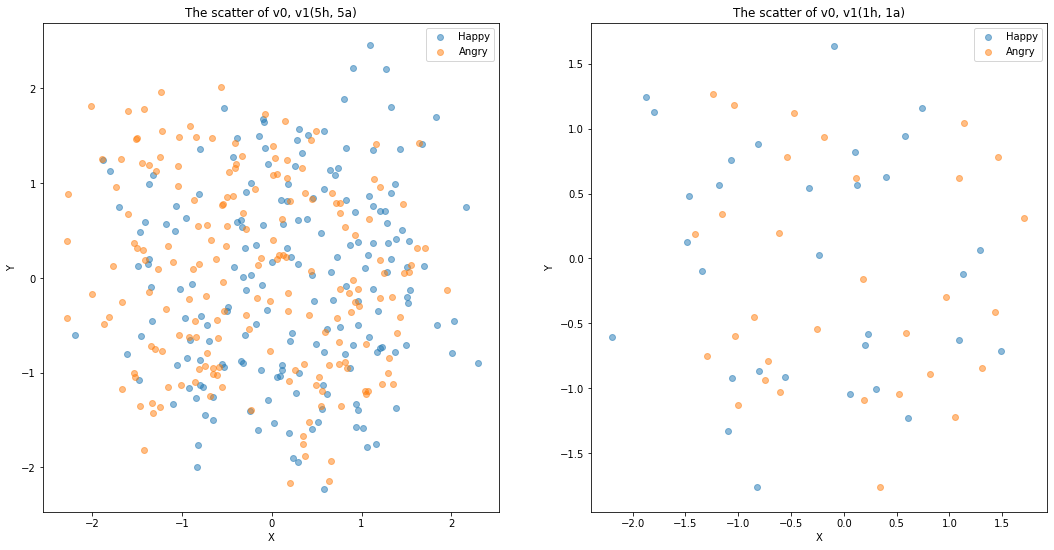

In [26]:
#visualize V0 and V1, v0 and v1 mean coordination of x,y
X_happy_x = []
X_happy_y = []
for i in range(len(X_std[y==3])):
    X_happy_x += list(X_std[y==3][i][:, 0])
    X_happy_y += list(X_std[y==3][i][:, 1])
    
X_angry_x = []
X_angry_y = []
for i in range(len(X_std[y==0])):
    X_angry_x += list(X_std[y==0][i][:, 0])
    X_angry_y += list(X_std[y==0][i][:, 1])  

fig = plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X_happy_x, X_happy_y, label="Happy", alpha = 0.5)
plt.scatter(X_angry_x, X_angry_y, label="Angry", alpha = 0.5)
plt.title("The scatter of v0, v1(5h, 5a)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_std[y==3][0][:, 0], X_std[y==3][0][:, 1], label="Happy", alpha = 0.5)
plt.scatter(X_std[y==0][0][:, 0], X_std[y==0][0][:, 1], label="Angry", alpha = 0.5)
plt.title("The scatter of v0, v1(1h, 1a)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

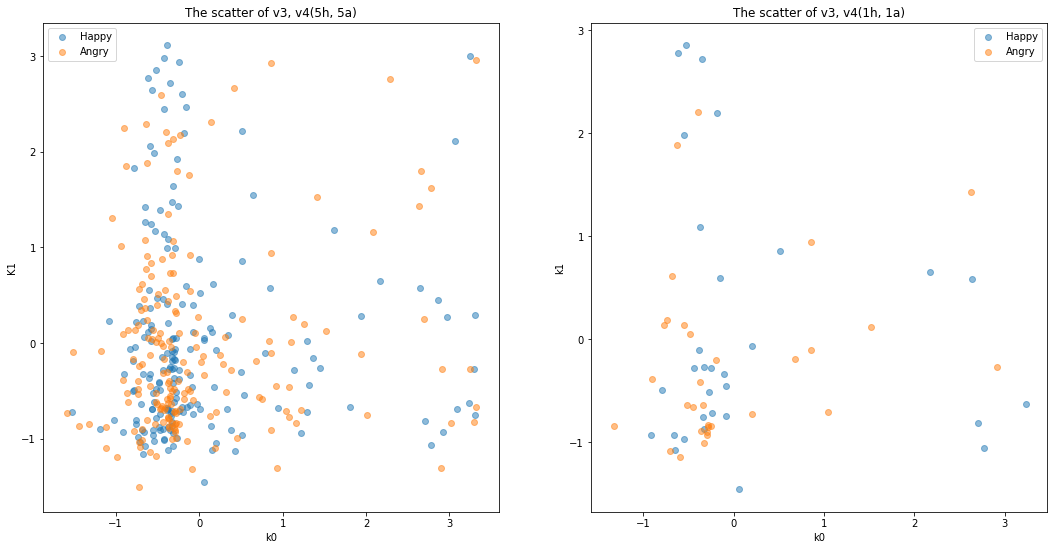

In [27]:
#visualize V0 and V3, they mean coordination of K0 and K0.
X_happy_x = []
X_happy_y = []
for i in range(len(X_std[y==3])):
    X_happy_x += list(X_std[y==3][i][:, 3])
    X_happy_y += list(X_std[y==3][i][:, 4])
    
X_angry_x = []
X_angry_y = []
for i in range(len(X_std[y==0])):
    X_angry_x += list(X_std[y==0][i][:, 3])
    X_angry_y += list(X_std[y==0][i][:, 4]) 
    
fig = plt.figure(figsize=(18,9))
plt.subplot(1,2,1)   
plt.scatter(X_happy_x, X_happy_y, label="Happy", alpha = 0.5)
plt.scatter(X_angry_x, X_angry_y, label="Angry", alpha = 0.5)
plt.title("The scatter of v3, v4(5h, 5a)")
plt.xlabel("k0")
plt.ylabel("K1")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_std[y==3][0][:, 3], X_std[y==3][0][:, 4], label="Happy", alpha = 0.5)
plt.scatter(X_std[y==0][0][:, 3], X_std[y==0][0][:, 4], label="Angry", alpha = 0.5)
plt.title("The scatter of v3, v4(1h, 1a)")
plt.xlabel("k0")
plt.ylabel("k1")
plt.legend()

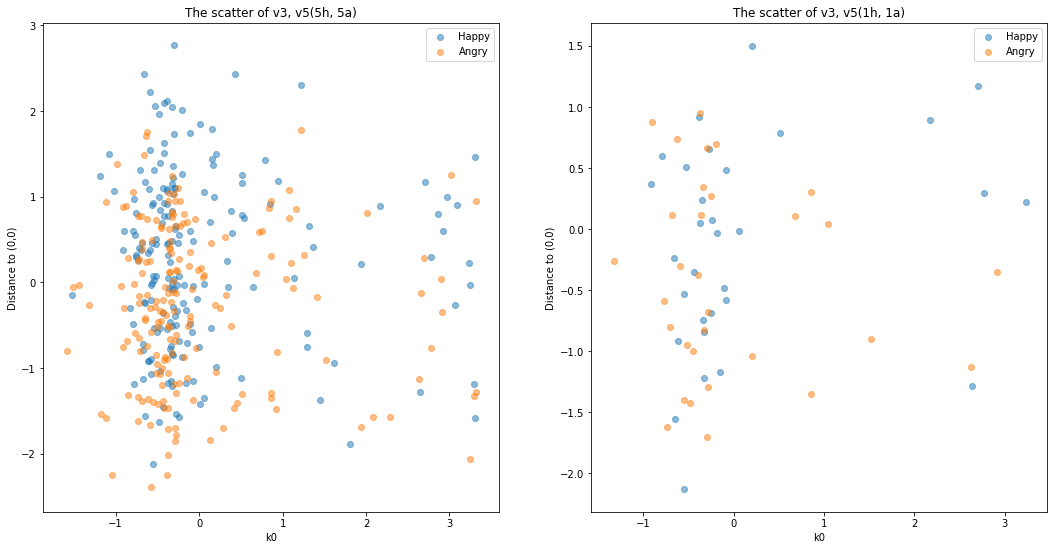

In [28]:
#visualize V0 and V3, they mean coordination of K0 and Dj.
X_happy_x = []
X_happy_y = []
for i in range(len(X_std[y==3])):
    X_happy_x += list(X_std[y==3][i][:, 3])
    X_happy_y += list(X_std[y==3][i][:, 5])
    
X_angry_x = []
X_angry_y = []
for i in range(len(X_std[y==0])):
    X_angry_x += list(X_std[y==0][i][:, 3])
    X_angry_y += list(X_std[y==0][i][:, 5])  
    
fig = plt.figure(figsize=(18,9))
plt.subplot(1,2,1)    
plt.scatter(X_happy_x, X_happy_y, label="Happy", alpha = 0.5)
plt.scatter(X_angry_x, X_angry_y, label="Angry", alpha = 0.5)
plt.title("The scatter of v3, v5(5h, 5a)")
plt.xlabel("k0")
plt.ylabel("Distance to (0,0)")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_std[y==3][0][:, 3], X_std[y==3][0][:, 5], label="Happy", alpha = 0.5)
plt.scatter(X_std[y==0][0][:, 3], X_std[y==0][0][:, 5], label="Angry", alpha = 0.5)
plt.title("The scatter of v3, v5(1h, 1a)")
plt.xlabel("k0")
plt.ylabel("Distance to (0,0)")
plt.legend()

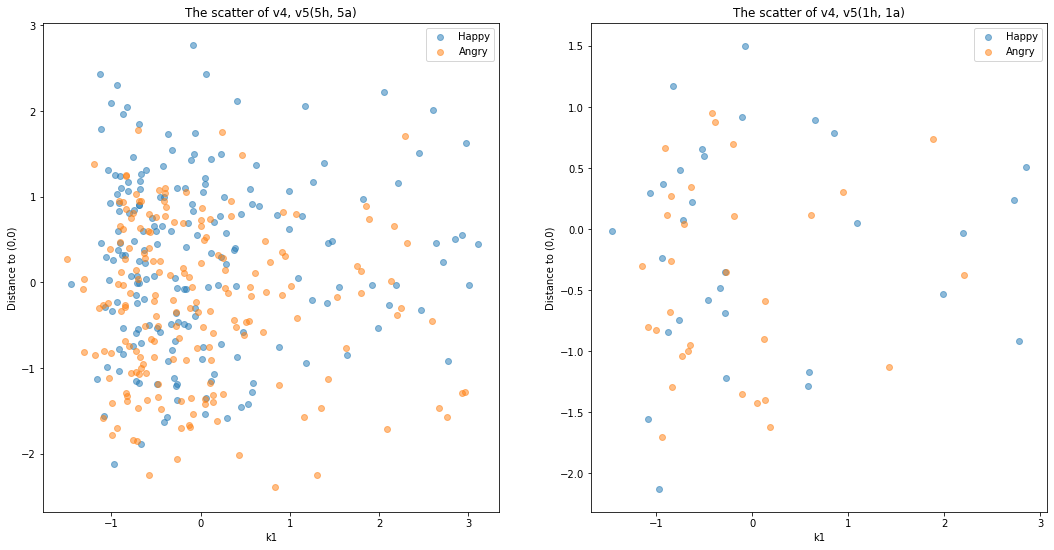

In [29]:
#visualize V0 and V3, they mean coordination of K1 and Dj.
X_happy_x = []
X_happy_y = []
for i in range(len(X_std[y==3])):
    X_happy_x += list(X_std[y==3][i][:, 4])
    X_happy_y += list(X_std[y==3][i][:, 5])
    
X_angry_x = []
X_angry_y = []
for i in range(len(X_std[y==0])):
    X_angry_x += list(X_std[y==0][i][:, 4])
    X_angry_y += list(X_std[y==0][i][:, 5])  

fig = plt.figure(figsize=(18,9))
plt.subplot(1,2,1)
plt.scatter(X_happy_x, X_happy_y, label="Happy", alpha = 0.5)
plt.scatter(X_angry_x, X_angry_y, label="Angry", alpha = 0.5)
plt.title("The scatter of v4, v5(5h, 5a)")
plt.xlabel("k1")
plt.ylabel("Distance to (0,0)")
plt.legend()

plt.subplot(1,2,2)
plt.scatter(X_std[y==3][0][:, 4], X_std[y==3][0][:, 5], label="Happy", alpha = 0.5)
plt.scatter(X_std[y==0][0][:, 4], X_std[y==0][0][:, 5], label="Angry", alpha = 0.5)
plt.title("The scatter of v4, v5(1h, 1a)")
plt.xlabel("k1")
plt.ylabel("Distance to (0,0)")
plt.legend()

# RBF and SVM

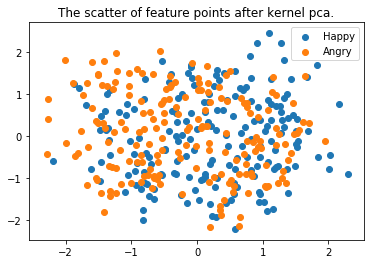

In [30]:
# visualize x after transfer from std and kenel pca
X_happy_x = []
X_happy_y = []
for i in range(len(X_std[y==3])):
    X_happy_x += list(X_std[y==3][i][:, 0])
    X_happy_y += list(X_std[y==3][i][:, 1])
    
X_angry_x = []
X_angry_y = []
for i in range(len(X_std[y==0])):
    X_angry_x += list(X_std[y==0][i][:, 0])
    X_angry_y += list(X_std[y==0][i][:, 1])  
    
plt.scatter(X_happy_x, X_happy_y, label="Happy")
plt.scatter(X_angry_x, X_angry_y, label="Angry")
plt.title("The scatter of feature points after kernel pca.")
plt.legend()

In [49]:
#reshape the X into model shape of input of model
X_reshape = []
for x in X_std:
    X_reshape.append(x.flatten())

In [52]:
from sklearn.svm import SVC
svc = SVC(gamma = "auto")
svc.fit(X_reshape, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [66]:
#evaluate model
mesh_eval = meshes[0]
X_eval = preprocessing_flow(mesh_eval)
svc.predict([np.array(X_eval).flatten()])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:118: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


array([3])